### Diffusion equation

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

**Initial Condition:**

$$y(x,0)=sin(\pi x)$$

**Boundary Conditions**

$$y(-1,t)=0$$
$$y(1,t)=0$$

**Exact solution:**

$$y(x,t)=e^{-t}sin(\pi x)$$

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Aux function ##
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [3]:
## Exact solution ##
def exact_solution(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

In [4]:
### Neural Network ###

class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes):
        super().__init__()
        layers = []
        # Adding input layer to the first hidden layer
        layers.append(nn.Linear(in_features, hidden_layer_sizes[0]))
        layers.append(nn.Tanh())  # Tanh activation function for this type of network is used
        # Adding hidden layers
        for i in range(len(hidden_layer_sizes) - 1):
            layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
            layers.append(nn.Tanh())  
        # Adding output layer
        layers.append(nn.Linear(hidden_layer_sizes[-1], out_features))
        
        # Combining all layers into a Sequential module
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class Net:
    def __init__(self):

        self.model = Model(
            in_features=2, 
            out_features=1, 
            hidden_layer_sizes=[20,20,20,20])
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # PDE
        # Here the matrix with the x and t coordinates is built
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        self.X.requires_grad = True
        
        # Boundary
        # Here the boundary conditions and initial conditions are set, the left hand-side
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic]).unsqueeze(1)
        

        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Boundary condition loss        
        y_pred = self.model(self.X_train)
        bc_loss = self.criterion(y_pred, self.y_train)

        # PDE loss
        u = self.model(self.X)
        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]
        
        loss_pde = torch.mean((
            du_dt - du_dxx + torch.exp(-self.X[:, 1].squeeze())*\
                (torch.sin(math.pi*self.X[:, 0].squeeze())\
                    - math.pi**2*torch.sin(math.pi*self.X[:, 0].squeeze())))**2)
        
        # Total loss
        loss = loss_pde + bc_loss
        loss.backward()
        
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        
        self.iter = self.iter + 1
        return loss
    
    def train(self, epochs):
        self.model.train()
        for i in range(epochs):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

In [6]:
## Training##
net = Net()
net.train(1000)

c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 4.446182727813721
200 1.335949420928955
300 0.1349480003118515
400 0.04502897709608078
500 0.021419523283839226
600 0.012745626270771027
700 0.009036144241690636
800 0.007339621894061565
900 0.006456019822508097
1000 0.005899387877434492
1100 0.001912017585709691
1200 0.0007335047703236341
1300 0.0004396733420435339
1400 0.00027553437394089997
1500 0.00021456574904732406
1600 0.0001723570458125323
1700 0.0001430833654012531
1800 0.00012007549230474979
1900 0.00010298326378688216
2000 7.97579123172909e-05
2100 6.280392699409276e-05
2200 5.390378282754682e-05
2300 4.448316030902788e-05
2400 4.140078090131283e-05
2500 3.64956067642197e-05
2600 3.270689194323495e-05
2700 2.901409607147798e-05
2800 2.7391901312512346e-05
2900 2.4875007511582226e-05
3000 2.313055119884666e-05
3100 2.1736723283538595e-05
3200 2.0892111933790147e-05
3300 1.9978748241555877e-05
3400 1.8876547983381897e-05
3500 1.7974776710616425e-05
3600 1.7188425772474147e-05
3700 1.6489879271830432e-05
3800 1.551888453832

In [7]:
## Evaluation ##

net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

In [8]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t))

In [9]:
# Exact values
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X, T = torch.meshgrid(x,t)
y_real = exact_solution(X,T)

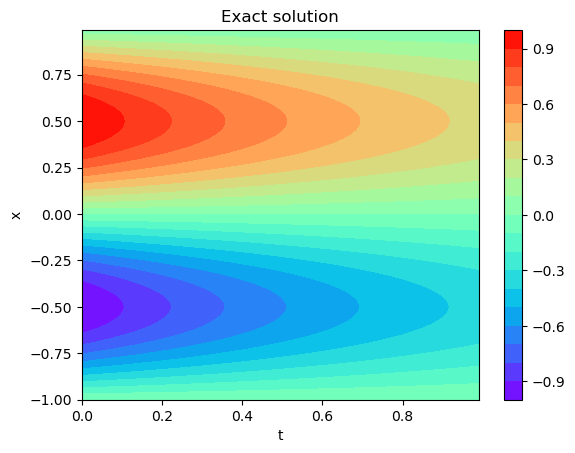

In [10]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(T,X, y_real,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Exact solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

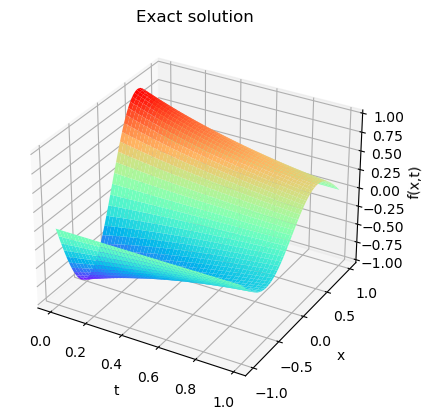

In [11]:
ax = plt.axes(projection='3d')
ax.plot_surface(T.numpy(), X.numpy(), y_real.numpy(),cmap="rainbow")
ax.set_title('Exact solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('f(x,t)')
plt.show()

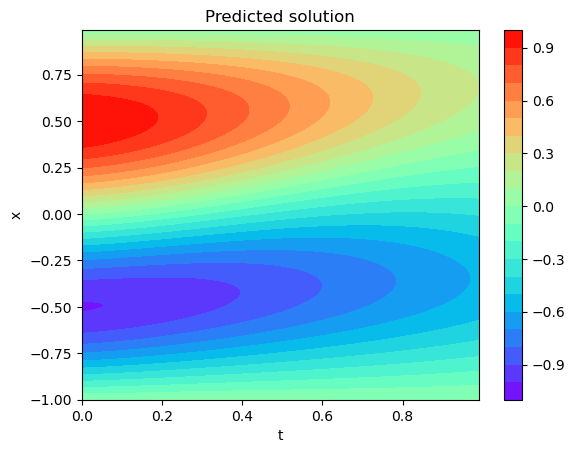

In [12]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(T, X, y_pred, 20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Predicted solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

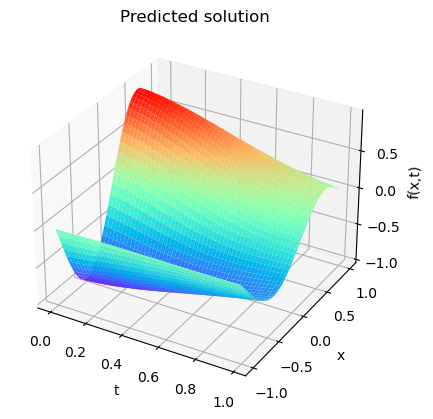

In [13]:
ax = plt.axes(projection='3d')
ax.plot_surface(T.numpy(), X.numpy(), y_pred.numpy(), cmap="rainbow")
ax.set_title('Predicted solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('f(x,t)')
plt.show()